In [28]:
import pandas as pd
import numpy as np
import sklearn
import re
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
#df1 = pd.read_csv('df_firstRound_final_ModelInputs.csv')
#df2 = pd.read_csv('df_secondRound_final_ModelInputs.csv')

df_raw1 = pd.read_csv('df_fistRound_finalData.csv')
df_raw2 = pd.read_csv('df_secondRound_finalData.csv')

df_departmentWinners = pd.read_csv('df_departmentWinners.csv')
df_voteDiff = pd.read_csv('df_voteDiff.csv')

In [30]:
#Attach the winner of the overall department from round 1

def getLePen(x):
    
    if x == 'LE PEN':
        return 1
    else:
        return 0

def getMacron(x):
    
    if x == 'MACRON':
        return 1
    else:
        return 0

    
df_departmentWinners['R1_Dept_Le_Pen'] = list(map(getLePen, df_departmentWinners['R1 Department Winner']))
df_departmentWinners['R1_Dept_Macron'] = list(map(getMacron, df_departmentWinners['R1 Department Winner']))

df_raw2 = pd.merge(df_raw2, df_departmentWinners, how='left', on='Department code')
df_raw2 = df_raw2.drop(['Unnamed: 0_x','Unnamed: 0_y','R1 Department Winner'], axis=1)

In [31]:
df_raw2.tail()

,Winner,Joiner,EU_circo,code_région,nom_région,chef.lieu_région,nom_département,préfecture,Constituency code,Commune_x,...,% Abs/Reg,% Voter/Reg,% NOTA/Reg,% NOTA/Voter,% Nulls/Reg,% Nulls/Voter,% Exp/Reg,% Exp/Voter,R1_Dept_Le_Pen,R1_Dept_Macron
31013,LE PEN,abaucourt-54001,Est,41.0,Lorraine,Metz,Meurthe-et-Moselle,Nancy,6.0,abaucourt,...,0.134694,0.865306,0.097959,0.113208,0.020408,0.023585,0.746939,0.863208,1,0
31014,LE PEN,abancourt-60001,Nord-Ouest,22.0,Picardie,Amiens,Oise,Beauvais,2.0,abancourt,...,0.168203,0.831797,0.052995,0.063712,0.011521,0.013850,0.767281,0.922438,1,0
31015,MACRON,abancourt-59001,Nord-Ouest,31.0,Nord-Pas-de-Calais,Lille,Nord,Lille,18.0,abancourt,...,0.159218,0.840782,0.053073,0.063123,0.030726,0.036545,0.756983,0.900332,1,0
31016,LE PEN,abainville-55001,Est,41.0,Lorraine,Metz,Meuse,Bar-le-Duc,1.0,abainville,...,0.213992,0.786008,0.057613,0.073298,0.028807,0.036649,0.699588,0.890052,1,0
31017,MACRON,aast-64001,Sud-Ouest,72.0,Aquitaine,Bordeaux,Pyrénées-Atlantiques,Pau,2.0,aast,...,0.133333,0.866667,0.109091,0.125874,0.042424,0.048951,0.715152,0.825175,0,1


In [32]:
#Rename some round 1 Commune_x to Towns
df_raw1 = df_raw1.rename(index=str, columns={'Commune_x':'Towns'})
df_raw2 = df_raw2.rename(index=str, columns={'Commune':'Towns'})

In [33]:
#Re-adjust 'Winner section to consider ties for the second round dataset
df_raw2 = pd.merge(df_raw2, df_voteDiff, how='left', on='Joiner')
df_r1TownWinner = df_raw1[['Winner', 'Joiner']]
df_raw2 = pd.merge(df_raw2, df_r1TownWinner, how='left', on='Joiner')
df_raw2 = df_raw2.drop(['Commune_x.1','INSEE code_x.1','Unnamed: 0'], axis=1)
df_raw2 = df_raw2.rename(index=str, columns={'Winner_x':'Winner','Commune_x':'Commune','INSEE code_x':'INSEE code','Winner_y':'R1_Winner','FirstPlace_Votes':'R1_FirstPlace_Votes','SecondPlace_Votes':'R1_FirstPlace_Votes','FirstSecond_Diff':'R1_FirstSecond_Diff'})
df_raw2['R1_Winner'] = df_raw2['R1_Winner'].fillna('Tie')

df_raw2.groupby('R1_Winner').count()

,Winner,Joiner,EU_circo,code_région,nom_région,chef.lieu_région,nom_département,préfecture,Constituency code,Commune,...,% NOTA/Voter,% Nulls/Reg,% Nulls/Voter,% Exp/Reg,% Exp/Voter,R1_Dept_Le_Pen,R1_Dept_Macron,R1_FirstPlace_Votes,R1_FirstPlace_Votes,R1_FirstSecond_Diff
R1_Winner,,,,,,,,,,,,,,,,,,,,,
ASSELINEAU,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
DUPONT-AIGNAN,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
FILLON,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738,...,4738,4738,4738,4738,4738,4738,4738,4738,4738,4738
HAMON,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
LASSALLE,64,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
LE PEN,16286,16286,16286,16286,16286,16286,16286,16286,16286,16286,...,16286,16286,16286,16286,16286,16286,16286,16286,16286,16286
MACRON,6142,6142,6142,6142,6142,6142,6142,6142,6142,6142,...,6142,6142,6142,6142,6142,6142,6142,6142,6142,6142
MÉLENCHON,2995,2995,2995,2995,2995,2995,2995,2995,2995,2995,...,2995,2995,2995,2995,2995,2995,2995,2995,2995,2995
Tie,772,772,772,772,772,772,772,772,772,772,...,772,772,772,772,772,772,772,772,772,772


In [34]:
#determine if a town voted for Macron or Le Pen in the first round
def getLePen(x):
    
    if x == 'LE PEN':
        return 1
    else:
        return 0

def getMacron(x):
    
    if x == 'MACRON':
        return 1
    else:
        return 0


df_raw2['R1_Town_Le_Pen'] = list(map(getLePen,df_raw2['R1_Winner']))
df_raw2['R1_Town_Macron'] = list(map(getMacron,df_raw2['R1_Winner']))

In [35]:
#Get the margin of victory in the first round in proportion to a towns population
def getMargin(pop, diff):
    
    return (diff/pop)

df_raw2['R1_VictoryMargin'] = list(map(getMargin, df_raw2['Total_Population'],df_raw2['R1_FirstSecond_Diff']))

In [36]:
#Lets bucket the age groups even more
def getAge(x,y):
    return x + y

def getAge2(x,y,z):
    return x + y + z

df_raw1['Youth_prop'] = list(map(getAge, df_raw1['Age_Under20_prop'], df_raw1['Age_20-29_prop']))
df_raw1['MiddleAge_prop'] = list(map(getAge2, df_raw1['Age_30-39_prop'],df_raw1['Age_40-49_prop'], df_raw1['Age_50-59_prop']))
df_raw1['OlderAge_prop'] = list(map(getAge2, df_raw1['Age_60-69_prop'],df_raw1['Age_70-79_prop'],df_raw1['Age_80Plus_prop']))

df_raw2['Youth_prop'] = list(map(getAge, df_raw2['Age_Under20_prop'], df_raw2['Age_20-29_prop']))
df_raw2['MiddleAge_prop'] = list(map(getAge2, df_raw2['Age_30-39_prop'],df_raw2['Age_40-49_prop'], df_raw2['Age_50-59_prop']))
df_raw2['OlderAge_prop'] = list(map(getAge2, df_raw2['Age_60-69_prop'],df_raw2['Age_70-79_prop'],df_raw2['Age_80Plus_prop']))

# Exploritory Data Analysis

Text(0.5,0,'')

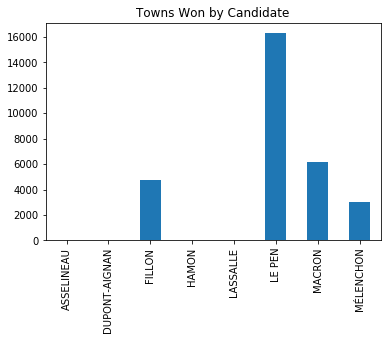

In [37]:
x = df_raw1.groupby('Winner').count().reset_index()
ax = x.plot(x='Winner',y='Towns', kind='bar', title='Towns Won by Candidate', legend=False)
ax.set_xlabel("")

In [11]:
#Get the vote percentage for all candidates in the first round:
df_candidates = df_raw1[['ARTHAUD','ASSELINEAU','CHEMINADE','DUPONT-AIGNAN','FILLON','HAMON','LASSALLE','LE PEN',
                         'MACRON','MÉLENCHON','POUTOU']]


def getTotals(df):

    theDict = {}
    totalPop = 0
    
    cols = df.columns.tolist()
    
    for col in cols:
        theDict[col] = 0
        theList = df[col].tolist()
        for i in theList:
            theDict[col] += i
            totalPop += i
    
    for x in theDict:
        theDict[x] *= (100/totalPop)
        
    return theDict

x = getTotals(df_candidates)


temp = []
dictList = []
 
for key, value in x.items():
    temp = [key,value]
    dictList.append(temp)
    
df_TotalVotes = pd.DataFrame(dictList)

Text(0,0.5,'')

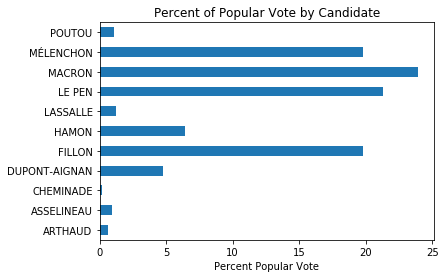

In [12]:
ax = df_TotalVotes.plot(x=0,y=1, kind='barh', title='Percent of Popular Vote by Candidate',legend=False)
ax.set_xlabel("Percent Popular Vote")
ax.set_ylabel("")

In [13]:
df_ageDist = df_raw1[['Winner','Age_Under20_prop','Age_20-29_prop','Age_30-39_prop','Age_40-49_prop','Age_50-59_prop','Age_60-69_prop','Age_70-79_prop','Age_80Plus_prop']]
df_ageDist.groupby('Winner').mean()

,Age_Under20_prop,Age_20-29_prop,Age_30-39_prop,Age_40-49_prop,Age_50-59_prop,Age_60-69_prop,Age_70-79_prop,Age_80Plus_prop
Winner,,,,,,,,
ASSELINEAU,0.088889,0.000000,0.000000,0.000000,0.088889,0.466667,0.177778,0.177778
DUPONT-AIGNAN,0.169744,0.038440,0.079442,0.183593,0.089861,0.130667,0.165730,0.142523
FILLON,0.226253,0.077928,0.110358,0.142529,0.148732,0.142997,0.087759,0.063443
HAMON,0.244861,0.029810,0.127313,0.160638,0.107746,0.178423,0.105583,0.045626
LASSALLE,0.190470,0.074652,0.092932,0.139380,0.172060,0.156780,0.088809,0.084919
LE PEN,0.248825,0.085075,0.122157,0.146839,0.143573,0.128624,0.072386,0.052521
MACRON,0.235673,0.079691,0.116103,0.144801,0.147556,0.137859,0.080487,0.057831
MÉLENCHON,0.216396,0.074832,0.112348,0.139188,0.153502,0.151316,0.087839,0.064579


Text(0,0.5,'')

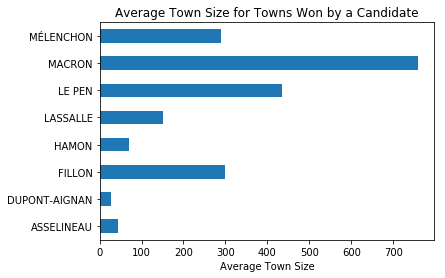

In [14]:
df_pop1 = df_raw1[['Winner','Total_Population']]
df_pop1 = df_pop1.rename(index=str, columns={'Total_Population':'Average Town Size'})
x = df_pop1.groupby('Winner').median().reset_index()

ax = x.plot(x='Winner', y='Average Town Size', title='Average Town Size for Towns Won by a Candidate', kind='barh',legend=False)
ax.set_xlabel("Average Town Size")
ax.set_ylabel("")

Text(0,0.5,'Towns Won')

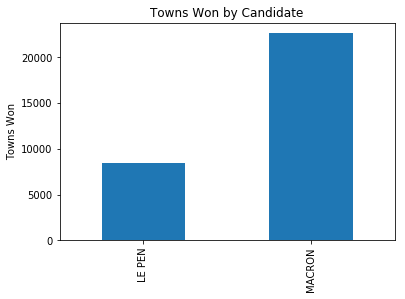

In [15]:
x = df_raw2.groupby('Winner').count().reset_index()

ax = x.plot(x='Winner',y='Total_Population', title='Towns Won by Candidate', kind='bar',legend=False)
ax.set_xlabel("")
ax.set_ylabel("Towns Won")

Text(0,0.5,'Average Margin of Victory')

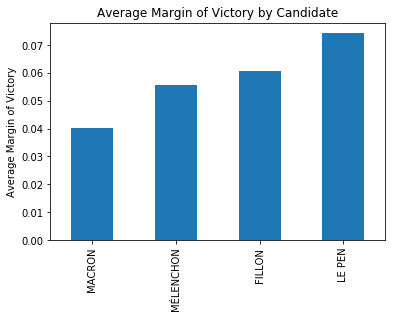

In [16]:
df_raw2.columns.tolist()

df_margin = df_raw2[['R1_Winner','R1_VictoryMargin']]
df_margin = df_margin[(df_margin['R1_Winner'] == 'MACRON') | (df_margin['R1_Winner'] == 'LE PEN') | (df_margin['R1_Winner'] == 'MÉLENCHON') | (df_margin['R1_Winner'] == 'FILLON')]
marg = df_margin.groupby('R1_Winner').mean().reset_index().sort_values(by='R1_VictoryMargin')


ax = marg.plot(x='R1_Winner', y='R1_VictoryMargin', title='Average Margin of Victory by Candidate', kind='bar',legend=False)
ax.set_xlabel("")
ax.set_ylabel("Average Margin of Victory")

In [17]:
#Abstentation figures:

R1_Abst = (df_raw1['Abstentions'].sum())/(df_raw1['Registered'].sum())*100
R2_Abst = (df_raw2['Abstentions'].sum())/(df_raw1['Registered'].sum())*100

print('Round One Abstentation: %.2f' % R1_Abst + '%')
print('Round Two Abstentation: %.2f' % R2_Abst + '%')

Round One Abstentation: 20.03%
Round Two Abstentation: 23.89%


In [19]:
#df_raw2.groupby('Winner').count()

x = df_raw2.groupby('Winner').count().reset_index()
#ax = x.plot(x='Winner',y='Towns', kind='bar', title='Towns Won by Candidate', legend=False)
#ax.set_xlabel("")

x

,Winner,Joiner,EU_circo,code_région,nom_région,chef.lieu_région,nom_département,préfecture,Constituency code,Commune,...,R1_FirstPlace_Votes,R1_FirstPlace_Votes,R1_FirstSecond_Diff,R1_Winner,R1_Town_Le_Pen,R1_Town_Macron,R1_VictoryMargin,Youth_prop,MiddleAge_prop,OlderAge_prop
0,LE PEN,8395,8395,8395,8395,8395,8395,8395,8395,8395,...,8395,8395,8395,8395,8395,8395,8395,8395,8395,8395
1,MACRON,22623,22623,22623,22623,22623,22623,22623,22623,22623,...,22623,22623,22623,22623,22623,22623,22623,22623,22623,22623


In [20]:
df_candidates = df_raw2[['LE PEN','MACRON']]

x = getTotals(df_candidates)


temp = []
dictList = []
 
for key, value in x.items():
    temp = [key,value]
    dictList.append(temp)
    
df_TotalVotes = pd.DataFrame(dictList)

Text(0,0.5,'')

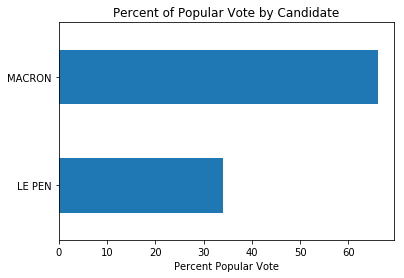

In [21]:
ax = df_TotalVotes.plot(x=0,y=1, kind='barh', title='Percent of Popular Vote by Candidate',legend=False)
ax.set_xlabel("Percent Popular Vote")
ax.set_ylabel("")

In [22]:
df_raw1.columns.tolist()

['Unnamed: 0',
 'Winner',
 'Joiner',
 'EU_circo',
 'code_région',
 'nom_région',
 'chef.lieu_région',
 'nom_département',
 'préfecture',
 'Constituency code',
 'Towns',
 'INSEE code_x',
 'latitude',
 'longitude',
 'Department code',
 'Registered',
 'Abstentions',
 'Voters',
 'None of the above(NOTA)',
 'Nulls',
 'Expressed',
 'Commune_x.1',
 'INSEE code_x.1',
 'ARTHAUD',
 'ASSELINEAU',
 'CHEMINADE',
 'DUPONT-AIGNAN',
 'FILLON',
 'HAMON',
 'LASSALLE',
 'LE PEN',
 'MACRON',
 'MÉLENCHON',
 'POUTOU',
 'Total_Population',
 'E14TST',
 'E14TS0ND',
 'E14TS1',
 'E14TS6',
 'E14TS10',
 'E14TS20',
 'E14TS50',
 'E14TS100',
 'E14TS200',
 'E14TS500',
 'genderRatio',
 'Age_Under20_prop',
 'Age_20-29_prop',
 'Age_30-39_prop',
 'Age_40-49_prop',
 'Age_50-59_prop',
 'Age_60-69_prop',
 'Age_70-79_prop',
 'Age_80Plus_prop',
 'Children_2Parents_prop',
 'Children_1Parent_prop',
 'NoChildren_Couple_prop',
 'Children_Couple_prop',
 'Children_Single_prop',
 'NoChildren_Adults_prop',
 'NoChildren_Alone_prop',
 '

In [23]:
# Get average youth proportion by town:
chee = df_raw1[['Winner', 'Youth_prop']]
chee.groupby('Winner').mean()

,Youth_prop
Winner,
ASSELINEAU,0.088889
DUPONT-AIGNAN,0.208184
FILLON,0.304181
HAMON,0.274671
LASSALLE,0.265122
LE PEN,0.333900
MACRON,0.315364
MÉLENCHON,0.291228


In [24]:
# Get average single adults proportion by town:
chee = df_raw1[['Winner', 'NoChildren_Alone_prop']]
chee.groupby('Winner').mean()

,NoChildren_Alone_prop
Winner,
ASSELINEAU,0.377778
DUPONT-AIGNAN,0.163187
FILLON,0.127021
HAMON,0.126731
LASSALLE,0.143911
LE PEN,0.109890
MACRON,0.123555
MÉLENCHON,0.146741


In [25]:
# Get average expressed votes vs. registered votes by town:
chee = df_raw1[['Winner', '% Exp/Reg']]
chee.groupby('Winner').mean()

,% Exp/Reg
Winner,
ASSELINEAU,0.707317
DUPONT-AIGNAN,0.785158
FILLON,0.818983
HAMON,0.832085
LASSALLE,0.802649
LE PEN,0.806991
MACRON,0.816503
MÉLENCHON,0.804335


In [26]:
#Get average margin of victory for first round and wins in the second round:
chee2 = df_raw2[['Winner','R1_VictoryMargin']]
chee2.groupby('Winner').mean()

,R1_VictoryMargin
Winner,
LE PEN,0.106080
MACRON,0.045595


Text(0,0.5,'Towns Won in Second Round')

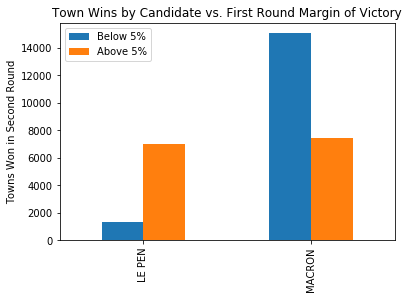

In [27]:
#Get graph of average margin of victory graph
df_raw2['Below 5%'] = df_raw2['R1_VictoryMargin'].apply(lambda x: 1 if x < 0.05 else 0)
df_raw2['Above 5%'] = df_raw2['R1_VictoryMargin'].apply(lambda x: 1 if x > 0.05 else 0)

df_raw2.head()

#Lets look at Macron
marg_Mac = df_raw2[['Winner','Below 5%','Above 5%']]
x = marg_Mac.groupby('Winner').sum().reset_index()

ax = x.plot(x='Winner',y=['Below 5%','Above 5%'], kind='bar', title='Town Wins by Candidate vs. First Round Margin of Victory')
ax.set_xlabel("")
ax.set_ylabel("Towns Won in Second Round")

In [26]:
# 
chee2 = df_raw2[['Winner','R1_Town_Le_Pen','R1_VictoryMargin']]
chee2.groupby(['Winner','R1_Town_Le_Pen']).mean()

R1_VictoryMargin
Winner R1_Town_Le_Pen                  
LE PEN 0                       0.059914
       1                       0.109922
MACRON 0                       0.047768
       1                       0.042009

Text(0,0.5,'Towns Won in Second Round')

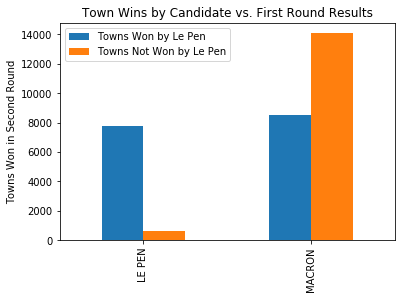

In [44]:
chee2 = df_raw2[['Winner','R1_Town_Le_Pen','R1_VictoryMargin']]
chee2.groupby(['Winner','R1_Town_Le_Pen']).count().reset_index()

d = {'Winner':['LE PEN','MACRON'], 'Towns Won by Le Pen':[7750, 8536],'Towns Not Won by Le Pen':[645, 14087]}
x = pd.DataFrame(data = d)

ax = x.plot(x='Winner',y=['Towns Won by Le Pen','Towns Not Won by Le Pen'], kind='bar', title='Town Wins by Candidate vs. First Round Results')
ax.set_xlabel("")
ax.set_ylabel("Towns Won in Second Round")

# Modeling

In [19]:
df_firstRound_final_ModelInputs = df_raw1.drop(['Unnamed: 0','Joiner','EU_circo','code_région','nom_région','chef.lieu_région','nom_département','préfecture','Constituency code','Towns',
                                                'INSEE code_x','latitude','longitude','Commune_x.1','INSEE code_x.1','ARTHAUD','ASSELINEAU','CHEMINADE','DUPONT-AIGNAN','FILLON',
                                                'HAMON','LASSALLE','LE PEN','MACRON','MÉLENCHON','POUTOU'], axis=1)

df_secondRound_final_ModelInputs = df_raw2.drop(['Joiner','EU_circo','code_région','nom_région','chef.lieu_région','nom_département','préfecture','Constituency code','Commune','INSEE code',
                                                 'latitude','longitude','LE PEN','MACRON','R1_Winner'], axis=1)

df_secondRound_final_ModelInputs['Department code'] = df_secondRound_final_ModelInputs['Department code'].astype(int)

In [20]:
#Check model with new features and take a closer look a feature importance
cols = list(df_firstRound_final_ModelInputs.columns.values)
X = df_firstRound_final_ModelInputs[cols[1:]]
y = df_firstRound_final_ModelInputs[cols[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=4444)

In [30]:
#Balanced Random Forest  class_weight='balanced'

model = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

Accuracy: 0.595
               precision    recall  f1-score   support

DUPONT-AIGNAN       0.00      0.00      0.00         4
       FILLON       0.45      0.09      0.15      1485
        HAMON       0.00      0.00      0.00         1
     LASSALLE       0.00      0.00      0.00        20
       LE PEN       0.61      0.93      0.74      4898
       MACRON       0.57      0.32      0.42      1828
    MÉLENCHON       0.48      0.12      0.20       838

  avg / total       0.56      0.60      0.52      9074



Feature ranking:
1. feature Department code (0.055177)
2. feature NoChildren_Alone_prop (0.038317)
3. feature Youth_prop (0.037493)
4. feature % Exp/Reg (0.035877)
5. feature % Abs/Reg (0.035051)
6. feature % Voter/Reg (0.034954)
7. feature Children_2Parents_prop (0.030668)
8. feature NoChildren_Couple_prop (0.029453)
9. feature Total_Population (0.028654)
10. feature Age_Under20_prop (0.028012)
11. feature Expressed (0.027503)
12. feature OlderAge_prop (0.027327)
13. feature Voters (0.026954)
14. feature E14TS0ND (0.026926)
15. feature Age_20-29_prop (0.025607)
16. feature Age_30-39_prop (0.025476)
17. feature Registered (0.025281)
18. feature E14TST (0.025204)
19. feature Children_Couple_prop (0.025048)
20. feature Age_80Plus_prop (0.024593)
21. feature Age_60-69_prop (0.024588)
22. feature genderRatio (0.023637)
23. feature Age_40-49_prop (0.023600)
24. feature Age_50-59_prop (0.023464)
25. feature MiddleAge_prop (0.023435)
26. feature % Exp/Voter (0.023359)
27. feature Age_70-79_pr

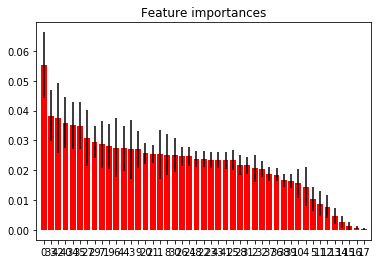

In [31]:
#Lets identify which features were the most important

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

cols = X_test.columns.tolist()

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [27]:
#Check model with new features and take a closer look a feature importance
cols = list(df_secondRound_final_ModelInputs.columns.values)
X2 = df_secondRound_final_ModelInputs[cols[1:]]
y2 = df_secondRound_final_ModelInputs[cols[0]]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,test_size=0.3, random_state=4444)

In [33]:
#Balanced Random Forest  class_weight='balanced'

model = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

model.fit(X_train2, y_train2)

print("Accuracy: %.3f"% accuracy_score(y_test2, model.predict(X_test2)))
print(classification_report(y_test2, model.predict(X_test2)))

Accuracy: 0.883
             precision    recall  f1-score   support

     LE PEN       0.82      0.72      0.77      2521
     MACRON       0.90      0.94      0.92      6785

avg / total       0.88      0.88      0.88      9306



Feature ranking:
1. feature R1_VictoryMargin (0.207025)
2. feature R1_Town_Le_Pen (0.156206)
3. feature R1_FirstSecond_Diff (0.068965)
4. feature R1_Dept_Le_Pen (0.045136)
5. feature R1_Dept_Macron (0.031489)
6. feature R1_Town_Macron (0.026804)
7. feature R1_FirstPlace_Votes (0.018836)
8. feature Expressed (0.018631)
9. feature R1_FirstPlace_Votes (0.018520)
10. feature Voters (0.018465)
11. feature R1_FirstPlace_Votes (0.017711)
12. feature R1_FirstPlace_Votes (0.017451)
13. feature Registered (0.016061)
14. feature Youth_prop (0.015571)
15. feature E14TS0ND (0.014680)
16. feature E14TST (0.014281)
17. feature None of the above(NOTA) (0.012996)
18. feature Children_2Parents_prop (0.012132)
19. feature % Exp/Voter (0.012126)
20. feature Total_Population (0.012104)
21. feature NoChildren_Couple_prop (0.011599)
22. feature Department code (0.011460)
23. feature % NOTA/Voter (0.010806)
24. feature OlderAge_prop (0.010676)
25. feature Age_Under20_prop (0.010638)
26. feature % NOTA/Reg (0.

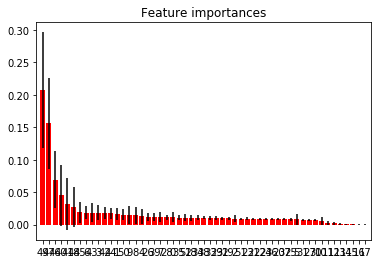

In [34]:
#Lets identify which features were the most important

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

cols = X_test2.columns.tolist()

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X2.shape[1]), indices)
plt.xlim([-1, X2.shape[1]])
plt.show()

In [96]:
#Lets try DecisionTree Classifier

model = DecisionTreeClassifier()
model.fit(X_train2, y_train2)

print("Accuracy: %.3f"% accuracy_score(y_test2, model.predict(X_test2)))
print(classification_report(y_test2, model.predict(X_test2)))

Accuracy: 0.829
             precision    recall  f1-score   support

     LE PEN       0.68      0.69      0.69      2521
     MACRON       0.89      0.88      0.88      6785

avg / total       0.83      0.83      0.83      9306



In [97]:
#Lets try Support Vector machine
model = SVC()
model.fit(X_train2, y_train2)

print("Accuracy: %.3f"% accuracy_score(y_test2, model.predict(X_test2)))
print(classification_report(y_test2, model.predict(X_test2)))

Accuracy: 0.730
             precision    recall  f1-score   support

     LE PEN       0.60      0.01      0.01      2521
     MACRON       0.73      1.00      0.84      6785

avg / total       0.69      0.73      0.62      9306



# Hyperparameter Tuning for Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [55]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [56]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=400, mi

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.4min


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True, total=  56.6s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True, total=  55.6s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total= 4.4min
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total= 4.4min
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1000,

[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, total= 7.2min
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total= 3.5min
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total= 3.6min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total= 7.7min
[CV] n_estimators=180

[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total= 4.8min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total= 4.7min
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total= 3.6min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total= 2.1min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, 

[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total= 2.2min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total= 3.0min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total= 1.1min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total= 1.1min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=400, mi

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 71.7min


[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total= 5.1min
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total= 5.1min
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total= 5.0min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total= 2.7min
[CV] n_estimator

[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True, total= 4.2min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=  42.7s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=  42.8s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=400, min_sa

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, total= 9.0min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, total= 8.8min
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total= 3.4min
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total= 2.0min
[CV] n_estimators=1600, 

[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total= 3.5min
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total= 3.5min
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total= 8.4min
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total= 8.3min
[CV]  n_estimator

[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total= 2.5min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total= 2.5min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False, total= 1.8min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=  48.8s
[CV] n_estimators=200,

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 150.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [57]:
#We can view the best parameters from fitting the random search:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 800}

In [62]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [90, 100, 110],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [700, 800, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [63]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700 
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700 
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=700 
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, m

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.2min


[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700, total= 2.0min
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total= 2.9min
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700, total= 2.0min
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total= 2.8min
[CV] bootstrap=False,

[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800, total= 2.2min
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=700, total= 1.9min
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total= 2.8min
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=1000 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=700, total= 1.9min
[CV] bootstrap=False, max_

[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700, total= 2.2min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800, total= 2.5min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800, total= 2.5min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800, total= 2.5min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=

[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000, total= 2.9min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=700, total= 2.0min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=700 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000, total= 2.9min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=700 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800, total= 2.3min
[CV] bootstr

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 46.2min


[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=700 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=700, total= 2.0min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=700 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=800, total= 2.2min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=700 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=800, total= 2.2min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=800, total= 2.2min
[CV] bootstrap=F

[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000, total= 3.2min
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000, total= 3.2min
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000, total= 3.2min
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=700, total= 2.2min
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700 
[CV]  bootst

[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=700, total= 2.0min
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=700, total= 1.9min
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total= 2.8min
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total= 2.8min
[CV] bootstrap

[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 76.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [False], 'max_depth': [90, 100, 110], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 5, 10], 'n_estimators': [700, 800, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [65]:

best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, X_train, y_train)

In [66]:
best_grid

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Final Model for Round 1